In [1]:
%run "ZeroMQ Python Connector".py
%load_ext autoreload
%autoreload
%matplotlib notebook
import pandas as pd

In [2]:
#Create connector instance, with particular port for PUSH, PULL and SUB
connector = DWX_ZeroMQ_Connector()

[INIT] Ready to send commands to METATRADER (PUSH): 32768
[INIT] Listening for responses from METATRADER (PULL): 32769
[INIT] Listening for market data from METATRADER (SUB): 32770


In [3]:
ID = connector._DWX_MTX_SEND_MARKETDATA_REQUEST_(_symbol='GBPUSD', _start=(Timestamp.now()-Timedelta(days=100)).strftime('%Y.%m.%d %H:%M:00'),_timeframe=1440,_end=Timestamp.now().strftime('%Y.%m.%d %H:%M:00'))
response = connector._get_response_(messageID = ID)
print("\n", response)

{'_messageID': 1426125734, '_action': 'DATA', '_data': {'2019.02.18 00:00': 1.29223, '2019.02.19 00:00': 1.30609, '2019.02.20 00:00': 1.30488, '2019.02.21 00:00': 1.30371, '2019.02.22 00:00': 1.3054, '2019.02.25 00:00': 1.30951, '2019.02.26 00:00': 1.32491, '2019.02.27 00:00': 1.33078, '2019.02.28 00:00': 1.32594, '2019.03.01 00:00': 1.32107, '2019.03.04 00:00': 1.31778, '2019.03.05 00:00': 1.31764, '2019.03.06 00:00': 1.31689, '2019.03.07 00:00': 1.30804, '2019.03.08 00:00': 1.30181, '2019.03.11 00:00': 1.31457, '2019.03.12 00:00': 1.307, '2019.03.13 00:00': 1.3335, '2019.03.14 00:00': 1.32401, '2019.03.15 00:00': 1.32926, '2019.03.18 00:00': 1.32522, '2019.03.19 00:00': 1.32637, '2019.03.20 00:00': 1.31898, '2019.03.21 00:00': 1.31043, '2019.03.22 00:00': 1.32094, '2019.03.25 00:00': 1.31958, '2019.03.26 00:00': 1.32017, '2019.03.27 00:00': 1.31854, '2019.03.28 00:00': 1.3038, '2019.03.29 00:00': 1.30292, '2019.04.01 00:00': 1.31035, '2019.04.02 00:00': 1.31307, '2019.04.03 00:00': 1

In [ ]:
response = Series(connector._get_response_())
responseData = Series(response["_data"])
print(type(responseData[0]))
order = connector._generate_default_order_dict()
print(order)

In [ ]:
order = connector._generate_default_order_dict()
connector._DWX_MTX_SEND_MARKETDATA_REQUEST_(_symbol='GBPUSD', _start=(Timestamp.now()-Timedelta(minutes=1)).strftime('%Y.%m.%d %H:%M:00'),_timeframe=1,_end=Timestamp.now().strftime('%Y.%m.%d %H:%M:00'))
response = Series(connector._get_response_())
responseData = Series(response["_data"])
order['_symbol'] = 'GBPUSD'
order['_price'] = responseData[0]
#connector._DWX_MTX_NEW_TRADE_(order)

In [ ]:
message = connector._DWX_MTX_GET_ALL_OPEN_TRADES_()
print(message)

In [26]:
def obtainMarketDataChunk(symbol,startTime, endTime, timeframe=1, data='DATA', chunkSize = 125):
    outputFrame = pd.DataFrame()
    chunkTime = timeframe * chunkSize 
    
    pdStartTime = Timestamp.strptime(startTime,'%Y.%m.%d %H:%M:00')
    pdEndTime = Timestamp.strptime(endTime,'%Y.%m.%d %H:%M:00')
    timeDelta = pdEndTime - pdStartTime 
    divMod = divmod(timeDelta,Timedelta(minutes=chunkTime))
    currentStartTime = None
    currentEndTime = None
    response = None
    print(divMod)
    
    for x in range(divMod[0]):
        print("--------------------------------------------------------------------------------------------------")
        oldResponse = connector._get_response_()
        currentStartTime = pdStartTime + (x*Timedelta(minutes=(chunkTime)))
        currentEndTime = pdStartTime + (x+1)*Timedelta(minutes=(chunkTime))
        ID = connector._DWX_MTX_SEND_MARKETDATA_REQUEST_(_symbol=symbol, _start=currentStartTime.strftime('%Y.%m.%d %H:%M:00'),
                                                    _timeframe=timeframe,_end=currentEndTime.strftime('%Y.%m.%d %H:%M:00'))
        
        response = connector._get_response_(messageID = ID)
        outputFrame = outputFrame.append(Series(response['_data']).to_frame()) # Append to dataframe
        sleep(0.1) # To prevent resource timeout
        print("--------------------------------------------------------------------------------------------------")
        
    
    print("--------------------------------------------------------------------------------------------------")
    ID = connector._DWX_MTX_SEND_MARKETDATA_REQUEST_(_symbol=symbol, _start=currentEndTime.strftime('%Y.%m.%d %H:%M:00'),
                                                _timeframe=timeframe,_end=endTime)

    response = connector._get_response_(messageID = ID)
    outputFrame = outputFrame.append(Series(response['_data']).to_frame())
    outputFrame = outputFrame.reset_index()
    outputFrame.rename(columns={'index':'Date', 0:'ClosePrice'}, inplace=True)
    outputFrame['Date'] = pd.to_datetime(outputFrame['Date'], format='%Y.%m.%d %H:%M')
    outputFrame = outputFrame.set_index('Date')
    print("--------------------------------------------------------------------------------------------------")
    return outputFrame


In [27]:
datachunk = obtainMarketDataChunk('GBPUSD', '2017.05.23 10:00:00', '2019.05.23 01:00:00',timeframe=1440)
print(datachunk.to_string())

(5, Timedelta('104 days 15:00:00'))
--------------------------------------------------------------------------------------------------
{'_messageID': 940369970, '_action': 'DATA', '_data': {'2017.05.24 00:00': 1.29726, '2017.05.25 00:00': 1.29401, '2017.05.26 00:00': 1.28068, '2017.05.29 00:00': 1.28391, '2017.05.30 00:00': 1.2857, '2017.05.31 00:00': 1.28883, '2017.06.01 00:00': 1.28805, '2017.06.02 00:00': 1.28908, '2017.06.05 00:00': 1.29039, '2017.06.06 00:00': 1.2906, '2017.06.07 00:00': 1.29564, '2017.06.08 00:00': 1.29484, '2017.06.09 00:00': 1.27431, '2017.06.12 00:00': 1.26571, '2017.06.13 00:00': 1.27516, '2017.06.14 00:00': 1.2748, '2017.06.15 00:00': 1.27558, '2017.06.16 00:00': 1.2777, '2017.06.19 00:00': 1.27359, '2017.06.20 00:00': 1.26289, '2017.06.21 00:00': 1.26705, '2017.06.22 00:00': 1.26814, '2017.06.23 00:00': 1.2719, '2017.06.26 00:00': 1.27216, '2017.06.27 00:00': 1.28135, '2017.06.28 00:00': 1.29229, '2017.06.29 00:00': 1.30043, '2017.06.30 00:00': 1.30272, '20

--------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
{'_messageID': 36283770, '_action': 'DATA', '_data': {'2018.10.08 00:00': 1.30838, '2018.10.09 00:00': 1.31421, '2018.10.10 00:00': 1.3188, '2018.10.11 00:00': 1.32188, '2018.10.12 00:00': 1.31513, '2018.10.15 00:00': 1.31506, '2018.10.16 00:00': 1.31718, '2018.10.17 00:00': 1.31122, '2018.10.18 00:00': 1.30165, '2018.10.19 00:00': 1.30666, '2018.10.22 00:00': 1.29561, '2018.10.23 00:00': 1.2982, '2018.10.24 00:00': 1.28815, '2018.10.25 00:00': 1.28155, '2018.10.26 00:00': 1.28281, '2018.10.29 00:00': 1.27929, '2018.10.30 00:00': 1.27066, '2018.10.31 00:00': 1.2765, '2018.11.01 00:00': 1.30002, '2018.11.02 00:00': 1.29688, '2018.11.05 00:00': 1.30417, '2018.11.06 00:00': 1.30997, '2018.11.07 00:00': 1.31276, '2018.11.08 00:00': 1.30602, '2018.11.09 00:00': 1.29736, '2018.11.12 00:00': 1.2849

<IPython.core.display.Javascript object>


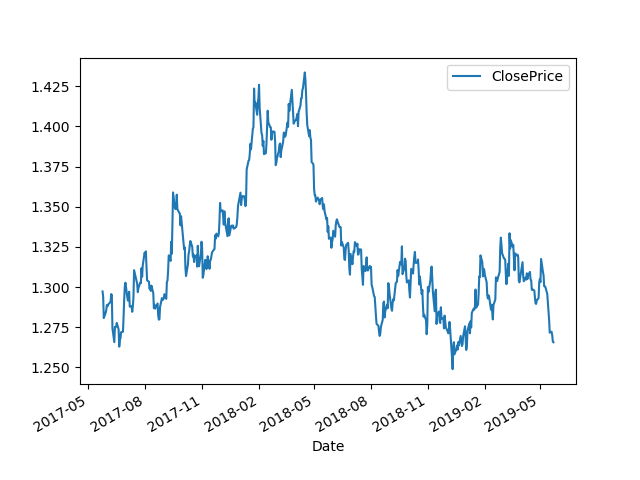

In [28]:
datachunk.plot()